In [1]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

In [2]:
#Check if the GPU is available
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [3]:
# Directory where the images are stored
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [4]:
# Function to load and resize images
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)
        return np.array(image) / 255.0  # Normaliza a imagem para a faixa [0, 1]
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [5]:
# Load training group IDs from a text file
ids_dark = r'C:\Users\bruna\OneDrive - Universidade do Minho\Microbialdataset\dark_images_ids.txt'

In [6]:
# Load training group IDs from a text file
with open(ids_dark, 'r') as file:
    ids = [line.strip() for line in file.readlines()]
    
print(f"Número de IDs carregados: {len(ids)}")
print(f"Primeiros 5 IDs: {ids[:5]}")

Número de IDs carregados: 9649
Primeiros 5 IDs: ['10000', '10001', '10002', '10003', '10004']


In [7]:
# Split the IDs into training and validation (e.g. 80 per cent for training and 20 per cent for validation)
split_index = int(len(ids) * 0.8)
train_ids = ids[:split_index]
val_ids = ids[split_index:]

In [8]:
%%capture
# Lists for storing image paths and corresponding labels
train_data = []
val_data = []

# Iterate over all the files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue

        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue

        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue

        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [9]:
# Check the number of images uploaded
print(f"Número de imagens no conjunto de treinamento: {len(train_data)}")
print(f"Número de imagens no conjunto de validação: {len(val_data)}")

Número de imagens no conjunto de treinamento: 7718
Número de imagens no conjunto de validação: 1930


In [10]:
# Separate images and labels
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)

In [11]:
# Convert the labels to the appropriate format (numeric)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [12]:
# One-Hot Encoding of labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [13]:
# Define a personalised data generator
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(112, 112)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [load_image(self.image_paths[i], self.target_size) for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [14]:
# Create training and validation generators
train_generator = DataGenerator(train_images, train_labels_one_hot, batch_size=32)
val_generator = DataGenerator(val_images, val_labels_one_hot, batch_size=32)

In [15]:
# Load the VGG16 base model with pre-trained weights from ImageNet
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [16]:
# Freeze VGG16 layers to train only customised layers
base_model_vgg16.trainable = False

In [17]:
# Add new layers on top of the base model
x = base_model_vgg16.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [18]:
#create the final model 
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

In [19]:
# Fine-tuning 
# Defrost the last layers of VGG16 for fine-tuning
for layer in base_model_vgg16.layers[-4:]:
    layer.trainable = True

In [22]:
# Recompile the model
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

In [23]:
# Train the model with fine-tuning
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
242/242 [==============================] - 2006s 8s/step - loss: 1.3666 - accuracy: 0.4368 - val_loss: 1.1575 - val_accuracy: 0.5461
Epoch 2/10
242/242 [==============================] - 1947s 8s/step - loss: 1.0709 - accuracy: 0.5889 - val_loss: 0.9381 - val_accuracy: 0.6534
Epoch 3/10
242/242 [==============================] - 1949s 8s/step - loss: 0.9456 - accuracy: 0.6424 - val_loss: 0.8537 - val_accuracy: 0.6534
Epoch 4/10
242/242 [==============================] - 1957s 8s/step - loss: 0.8675 - accuracy: 0.6771 - val_loss: 0.7085 - val_accuracy: 0.7782
Epoch 5/10
242/242 [==============================] - 2083s 9s/step - loss: 0.8008 - accuracy: 0.7029 - val_loss: 0.6363 - val_accuracy: 0.7762
Epoch 6/10
242/242 [==============================] - 1955s 8s/step - loss: 0.7607 - accuracy: 0.7186 - val_loss: 0.5924 - val_accuracy: 0.7902
Epoch 7/10
242/242 [==============================] - 1954s 8s/step - loss: 0.7188 - accuracy: 0.7323 - val_loss: 0.5571 - val_accuracy:

In [24]:
# save the model
model_vgg16.save('trained_model.vgg16_dark')

INFO:tensorflow:Assets written to: trained_model.vgg16_dark\assets


INFO:tensorflow:Assets written to: trained_model.vgg16_dark\assets


In [25]:
# Evaluate the model using the validation data generator
val_loss_vgg16, val_accuracy_vgg16 = model_vgg16.evaluate(val_generator)
print(f"Loss on validation set: {val_loss_vgg16}")
print(f"Accuracy on validation set: {val_accuracy_vgg16}")

61/61 [==============================] - 364s 6s/step - loss: 0.5065 - accuracy: 0.8130
Loss on validation set: 0.506476104259491
Accuracy on validation set: 0.8129533529281616


In [26]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

# Load and process the validation images
val_images_processed = np.array([load_image(img_path) for img_path in val_images])

# Check if any images haven't loaded correctly
val_images_processed = np.array([img for img in val_images_processed if img is not None])

# Get predictions from the model
val_predictions = model_vgg16.predict(val_images_processed)

# Convert one-hot encoded predictions to labels
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# confusion matrix
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

#  Classification report
target_names = label_encoder.classes_  # Usar as classes reais
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

61/61 [==============================] - 54s 875ms/step
Matriz de Confusão:
[[327  62  22  51   6]
 [  2 284   2  19  12]
 [  3   3 333  15   6]
 [  4  13  28 319   1]
 [  2  60  14  36 306]]
Relatório de Classificação:
              precision    recall  f1-score   support

  B.subtilis       0.97      0.70      0.81       468
  C.albicans       0.67      0.89      0.77       319
      E.coli       0.83      0.93      0.88       360
P.aeruginosa       0.72      0.87      0.79       365
    S.aureus       0.92      0.73      0.82       418

    accuracy                           0.81      1930
   macro avg       0.82      0.82      0.81      1930
weighted avg       0.84      0.81      0.81      1930



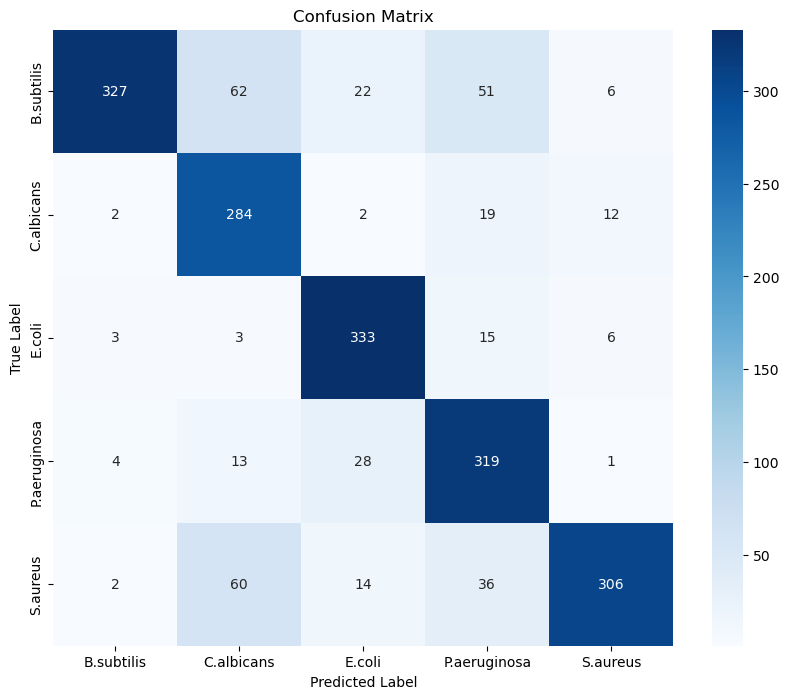

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualise the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Load the saved model
from tensorflow.keras.models import load_model

model_vgg16 = load_model('trained_model.vgg16_dark')


In [31]:
# Reload the validation images, if necessary
val_images_processed = np.array([load_image(img_path) for img_path in val_images])

# Check that all images have been uploaded correctly
val_images_processed = np.array([img for img in val_images_processed if img is not None])

# Generate forecasts using the loaded model
val_predictions = model_vgg16.predict(val_images_processed)

# Convert forecasts to labels
val_predictions_labels = np.argmax(val_predictions, axis=1)

61/61 [==============================] - 43s 701ms/step


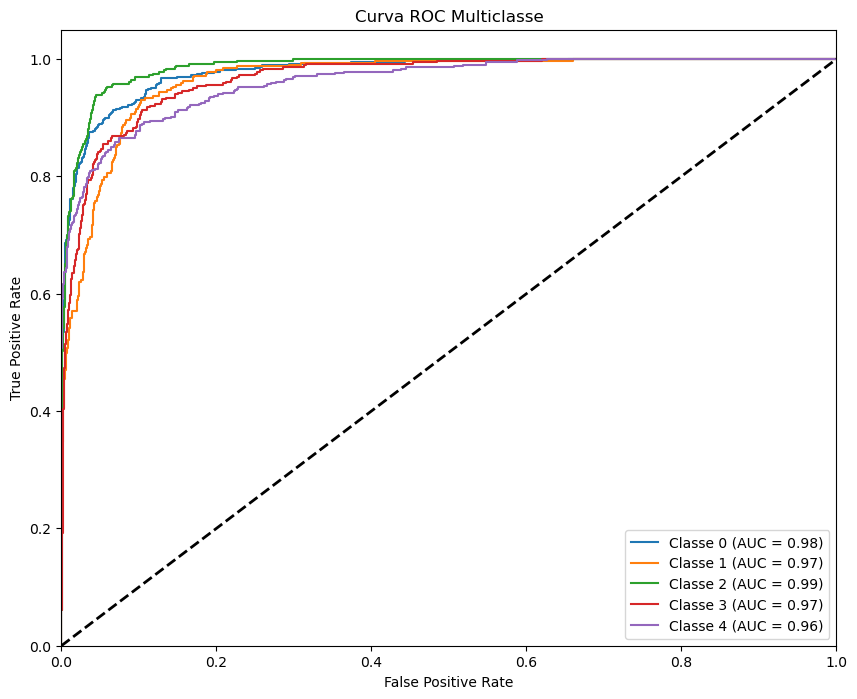

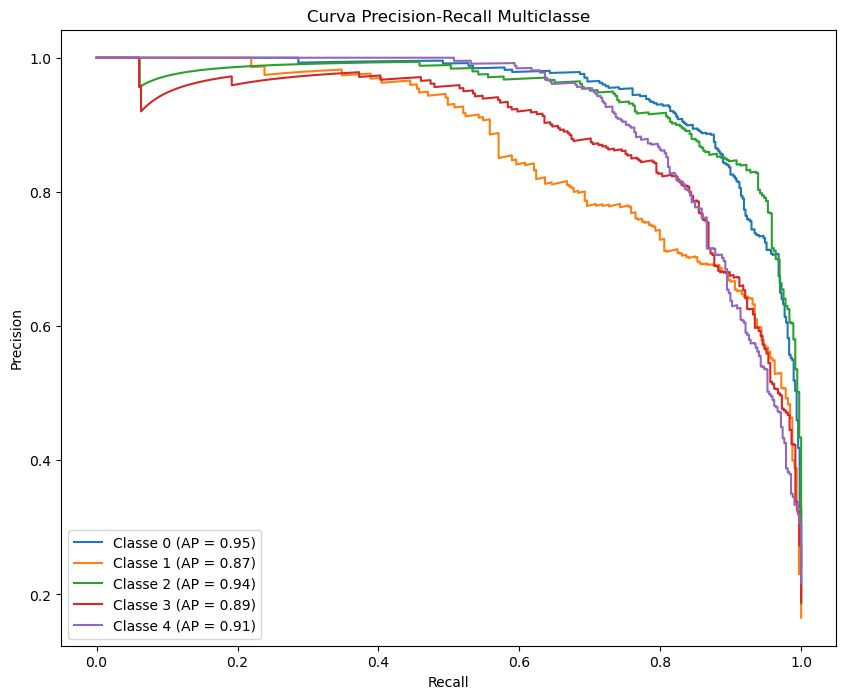

In [33]:
# Function to plot the ROC curve for each class
def plot_roc_curve(val_labels, val_predictions):
    num_classes = val_labels.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(val_labels[:, i], val_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC Multiclasse')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot the PRC curve for each class and calculate AP
def plot_prc_curve(val_labels, val_predictions):
    num_classes = val_labels.shape[1]
    precision = {}
    recall = {}
    average_precision = {}

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(val_labels[:, i], val_predictions[:, i])
        average_precision[i] = average_precision_score(val_labels[:, i], val_predictions[:, i])
        plt.plot(recall[i], precision[i], label=f'Classe {i} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall Multiclasse')
    plt.legend(loc="lower left")
    plt.show()

## Plot curves
plot_roc_curve(val_labels_one_hot, val_predictions)
plot_prc_curve(val_labels_one_hot, val_predictions)